PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.0/-118.0 degree
PYSOLID: start UTC: 2020-01-01T04:00:00
PYSOLID: end   UTC: 2021-01-01T02:00:00
PYSOLID: time step: 300 seconds


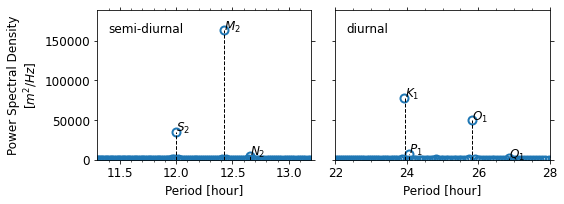

Text(0, 0.5, 'Displacement [mm]')

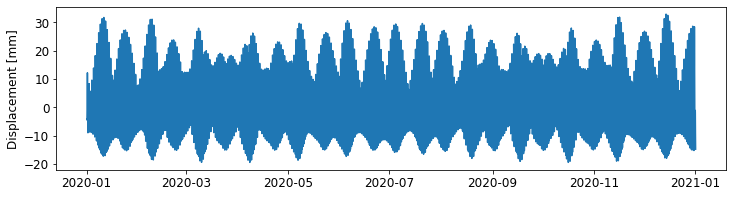

In [20]:
import os
import pysolid
import numpy as np
import datetime as dt
from mintpy.utils import plot as pp
from cartopy import crs as ccrs, feature as cfeature
from matplotlib import pyplot as plt, ticker, dates as mdates

%matplotlib inline
plt.rcParams.update({'font.size': 12})


# prepare inputs
lat, lon = 34.0, -118.0                 # point of interest in degree, Los Angles, CA
step_sec = 60 * 5                       # sample spacing in time domain in seconds
dt0 = dt.datetime(2020, 1, 1, 4, 0, 0)  # start date and time
dt1 = dt.datetime(2021, 1, 1, 2, 0, 0)  # end   date and time

# compute SET via pysolid
(dt_out,
 tide_e,
 tide_n,
 tide_u) = pysolid.calc_solid_earth_tides_point(lat, lon, dt0, dt1,
                                                step_sec=step_sec,
                                                display=False,
                                                verbose=False)

# plot the power spectral density of SET up component
pysolid.plot_power_spectral_density4tides(tide_u, sample_spacing=step_sec)

# plot timeseries of SET at that point
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 3])
ax.plot(dt_out, tide_u*100, lw=1.5)
ax.set_ylabel('Displacement [mm]')

PYSOLID: ----------------------------------------
PYSOLID: datetime: 2020-12-25T14:07:44
PYSOLID: SNWE: (29.11111, 43.0, -126.0, -113.499999)
SOLID  : calculate solid Earth tides in east/north/up direction
SOLID  : shape: (500, 450), step size: -0.0278 by 0.0278 deg
SOLID  : calculating / writing data to txt file: /home/ykliu/tmp/solid.txt
PYSOLID: read data from text file: /home/ykliu/tmp/solid.txt
plot lat/lon label in step of 10 and location of [1, 0, 0, 1]
plot lat/lon label in step of 10 and location of [0, 0, 0, 1]
plot lat/lon label in step of 10 and location of [0, 0, 0, 1]
plot lat/lon label in step of 10 and location of [0, 0, 0, 1]
save figure to file: SET_grid.png


/home/ykliu/apps/Anaconda/envs/insar/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


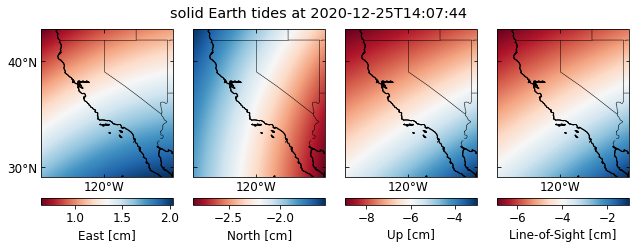

In [18]:

# prepare inputs
dt_obj = dt.datetime(2020, 12, 25, 14, 7, 44)
atr = {
    'LENGTH' : 500,                # number of rows
    'WIDTH'  : 450,                # number of columns
    'X_FIRST': -126,               # min longitude in degree (upper left corner of the upper left pixel)
    'Y_FIRST': 43,                 # max laitude   in degree (upper left corner of the upper left pixel)
    'X_STEP' :  0.000925926 * 30,  # output resolution in degree
    'Y_STEP' : -0.000925926 * 30,  # output resolution in degree
}

# compute SET via pysolid
(tide_e,
 tide_n,
 tide_u) = pysolid.calc_solid_earth_tides_grid(dt_obj, atr,
                                               display=False,
                                               verbose=True)

# project SET from ENU to radar line-of-sight (LOS) direction with positive for motion towards satellite
inc_angle  =   34.0 / 180. * np.pi  # radian, typical value for Sentinel-1
head_angle = -168.0 / 180. * np.pi  # radian, typical value for Sentinel-1 desc track
tide_los = (  tide_e * np.sin(inc_angle) * np.cos(head_angle) * -1
            + tide_n * np.sin(inc_angle) * np.sin(head_angle)
            + tide_u * np.cos(inc_angle))


# plot
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[9, 5], sharex=True, sharey=True, subplot_kw=dict(projection=ccrs.PlateCarree()))

N = float(atr['Y_FIRST'])
W = float(atr['X_FIRST'])
S = N + float(atr['Y_STEP']) * int(atr['LENGTH'])
E = W + float(atr['X_STEP']) * int(atr['WIDTH'])
kwargs = dict(cmap='RdBu',
              origin='upper',
              extent=(W,E,S,N),
              interpolation='nearest')

tides = [tide_e, tide_n, tide_u, tide_los]
labels = ['East [cm]', 'North [cm]', 'Up [cm]', 'Line-of-Sight [cm]']
lalo_locs = [[1,0,0,1],
             [0,0,0,1],
             [0,0,0,1],
             [0,0,0,1]]  # left, right, top, bottom
for i in range(len(tides)):
    ax = axs[i]
    im = ax.imshow(tides[i]*100, **kwargs)

    # axis format
    ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True)
    ax.coastlines(resolution='10m')

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='k', linewidth=0.5)

    pp.draw_lalo_label(geo_box=(W,N,E,S), ax=ax, projection=ccrs.PlateCarree(), lalo_loc=lalo_locs[i], lalo_step=10)
    fig.colorbar(im, ax=ax, orientation='horizontal', label=labels[i], pad=0.07, ticks=ticker.MaxNLocator(3))
fig.suptitle('solid Earth tides at {}'.format(dt_obj.isoformat()), y=0.7)
fig.tight_layout()

# output
out_fig = 'SET_grid.png'
print('save figure to file:', out_fig)
#fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

In [21]:
%matplotlib inline
import os
import datetime as dt
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt, ticker, dates as mdates
import pysolid
plt.rcParams.update({'font.size': 16})

work_dir = os.path.expanduser('~/tmp')
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /home/ykliu/tmp


In [22]:
# inputs
lat, lon = 30.0, 35.0 # Aqaba, Egypt
step_sec = 60 * 10
dt0 = dt.datetime(2001,1,1,4,0,0)
#dt0 = dt.datetime(2020,1,1,4,0,0)
dt1 = dt.datetime(2021,1,1,2,0,0)

# run
(dt_out,
 tide_e,
 tide_n,
 tide_u) = pysolid.calc_solid_earth_tides_point(lat, lon, dt0, dt1,
                                                step_sec=step_sec,
                                                display=False,
                                                verbose=False)

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 30.0/35.0 degree
PYSOLID: start UTC: 2001-01-01T04:00:00
PYSOLID: end   UTC: 2021-01-01T02:00:00
PYSOLID: time step: 600 seconds


In [23]:
# Get SLC acquisition dates
N=60
slc_t = []
slc_d = []
for i in range(N):
    slc_t.append(dt_out[945718+(i*12*24*6)])
    slc_d.append(tide_u[945718+(i*12*24*6)])

slc_t = np.array(slc_t)
slc_d = np.array(slc_d)

save figure to file: SET_TS_Up.png


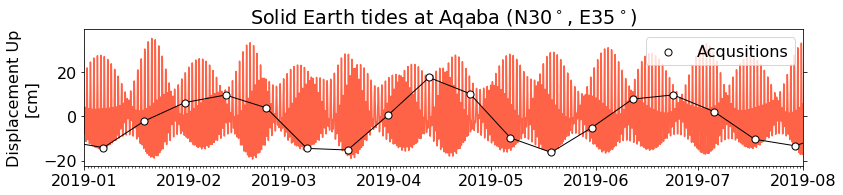

In [24]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[12, 3])
ax.plot(dt_out, tide_u*100, lw=1.5, c='tomato')
ax.plot(slc_t,  slc_d*100, lw=1, c='k')
ax.scatter(slc_t,  slc_d*100, s=50, fc='w', ec='k' ,marker='o', zorder=3, label='Acqusitions')

# axis format
ax.tick_params(which='both', direction='out', bottom=True, top=False, left=True, right=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_ylabel('Displacement Up\n[cm]')
ax.set_title(r'Solid Earth tides at Aqaba (N30$^\circ$, E35$^\circ$)')
ax.set_xlim(dt.datetime(2019,1,1), dt.datetime(2019,8,1))
plt.legend(loc='upper right')
fig.tight_layout()

# output
out_fig = 'SET_TS_Up.png'
print('save figure to file:', out_fig)
#fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

save figure to file: /home/ykliu/tmp/SET_PSD.png


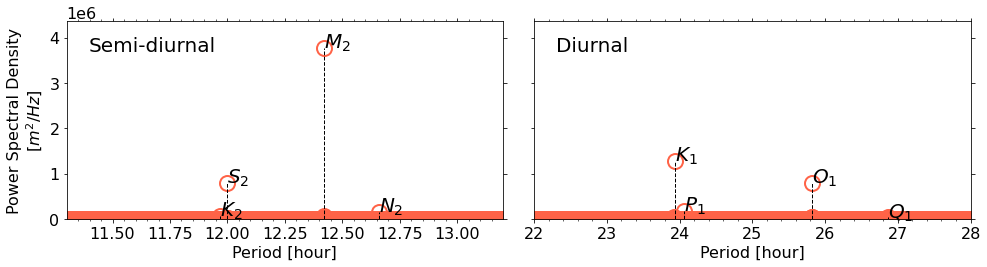

In [5]:
## calc PSD
freq, psd = signal.periodogram(tide_u, fs=1/step_sec, scaling='density')
# get rid of zero in the first element
psd = psd[1:]
freq = freq[1:]
period = 1./3600./freq   # period (hour)

## plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[14,4], sharey=True)
for ax in axs:
    ax.plot(period, psd, '.', ms=30, mfc='none', mew=2, c='tomato')

# axis format
for ax in axs:
    ax.tick_params(which='both', direction='out', bottom=True, top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlabel('Period [hour]')
axs[0].set_xlim(11.3, 13.2)
axs[1].set_xlim(22.0, 28.0)
ax = axs[0]
ax.set_ylabel('Power Spectral Density\n'+r'[$m^2/Hz$]')
ax.set_ylim(0, ymax=axs[0].get_ylim()[1] * 1.1)
#plt.yscale('log')
#ax.yaxis.set_major_locator(ticker.FixedLocator([0,50e3,100e3,150e3]))
#ax.set_yticklabels(['0','50k','100k','150k'])
fig.tight_layout()

# Tidal constituents
plt.rcParams.update({'font.size': 20})
for ax in axs:
    pysolid.point.add_tidal_constituents(ax, period, psd, min_psd=0.02e6)
axs[0].annotate('Semi-diurnal', xy=(0.05,0.85), xycoords='axes fraction')
axs[1].annotate('Diurnal',      xy=(0.05,0.85), xycoords='axes fraction')
plt.rcParams.update({'font.size': 16})


# output
out_fig = 'SET_PSD.png'
if out_fig:
    print('save figure to file:', os.path.abspath(out_fig))
    fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

save figure to file: /home/ykliu/tmp/SET_PSD_short.png


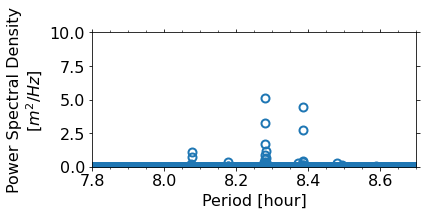

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6,3], sharey=True)
ax.plot(period, psd, '.', ms=16, mfc='none', mew=2)

# axis format
ax.tick_params(which='both', direction='out', bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('Period [hour]')
ax.set_ylabel('Power Spectral Density\n'+r'[$m^2/Hz$]')
ax.set_xlim(7.8, 8.7)
ax.set_ylim(0, 10)
#plt.yscale('log')
fig.tight_layout()

# output
out_fig = 'SET_PSD_short.png'
if out_fig:
    print('save figure to file:', os.path.abspath(out_fig))
    fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()

save figure to file: /home/ykliu/tmp/SET_PSD_long.png


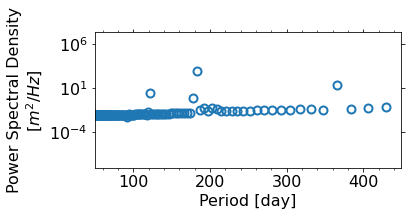

In [7]:
# get period in days
period = 1./(3600.*24.)/freq   # period (hour)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6,3], sharey=True)
ax.plot(period, psd, '.', ms=16, mfc='none', mew=2)

# axis format
ax.tick_params(which='both', direction='out', bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('Period [day]')
ax.set_xlim(50, 450)
#ax.set_ylim(0, 10)
ax.set_ylabel('Power Spectral Density\n'+r'[$m^2/Hz$]')
plt.yscale('log')
fig.tight_layout()

# output
out_fig = 'SET_PSD_long.png'
if out_fig:
    print('save figure to file:', os.path.abspath(out_fig))
    fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=600)
plt.show()